In [6]:
using Revise, MDToolbox, Plots, JLD2, Printf, DelimitedFiles
include("mathTool.jl")
include("plotTool.jl")
include("BioAFMResult.jl")

BioAFMResult

  0.124870 seconds (93.69 k allocations: 205.493 MiB, 33.57% gc time)
  0.078873 seconds (43.78 k allocations: 203.063 MiB, 32.30% gc time)
  0.083244 seconds (43.78 k allocations: 203.063 MiB, 32.34% gc time)
  0.085525 seconds (43.78 k allocations: 203.063 MiB, 32.53% gc time)


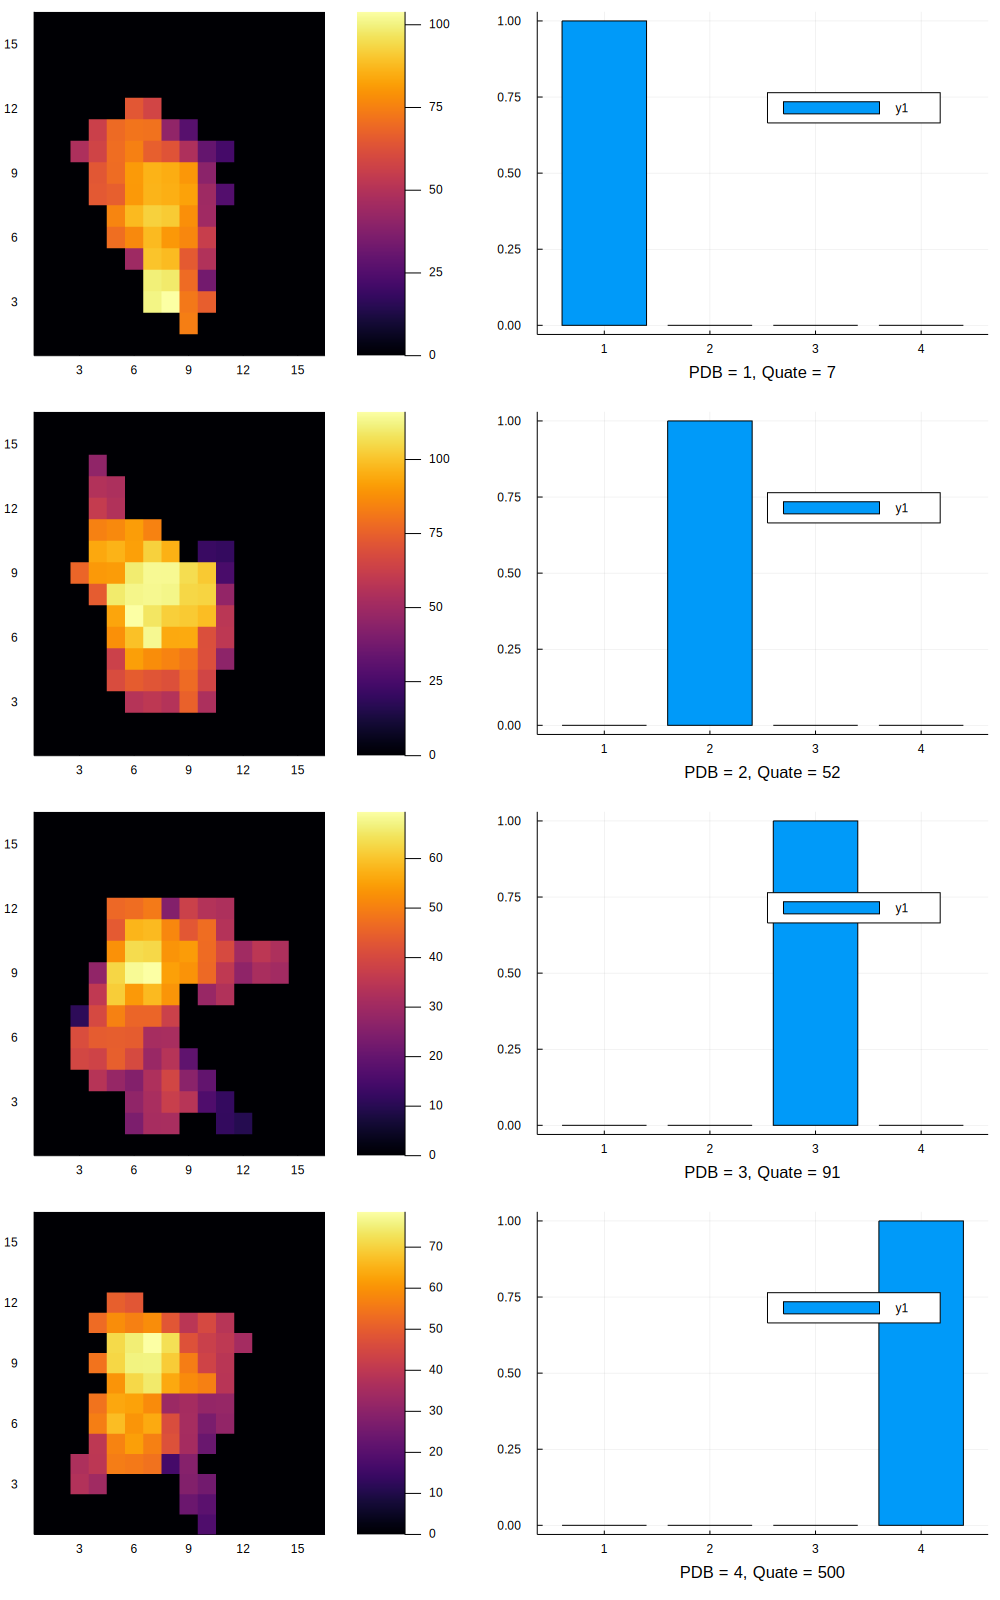

In [8]:
function BioAFM_Quate(afmData, pdbList, quateList, sigma)::BioAFMResult
    imgHeight, imgWidth = size(afmData)
    pdbNum = size(pdbList, 1)
    quateNum = size(quateList, 1)
    posteriors = Float64[]
    mostPlausible = Float64(0)
    mostPlausiblePDB = Int(0)
    mostPlausibleQuate = Int(0)

    for pdbId in 1:pdbNum
        sumPlausible = Float64(0)
        for quateId in 1:quateNum

            pdbRotated = MDToolbox.rotate(pdbList[pdbId], quateList[quateId, :])
            nowAfmData = MDToolbox.afmize(pdbRotated, (150.0, 150.0), (imgHeight, imgWidth))
            nowPlausible = gaussian(nowAfmData, afmData, sigma)
            sumPlausible += nowPlausible
            if mostPlausible < nowPlausible
                mostPlausible = nowPlausible
                mostPlausiblePDB = pdbId
                mostPlausibleQuate = quateId
            end
        end
        push!(posteriors, sumPlausible)
    end
    posteriors ./= sum(posteriors)
    return BioAFMResult(posteriors, mostPlausiblePDB, mostPlausibleQuate)
end

quateList = DelimitedFiles.readdlm("quaternion/QUATERNION_LIST_576_Orient")
pdbList = [MDToolbox.readpdb("model/0000$(i).pdb") for i in 1:4]
MDToolbox.decenter!.(pdbList)
@load "testcase/fileNameList.jld2" fileNameList

resultList = BioAFMResult[]
afmDatas = []
for fileName in fileNameList
    @load fileName afmData
    @time result = BioAFM_Quate(afmData, pdbList, quateList, 10)
    push!(afmDatas, afmData)
    push!(resultList, result)
end

plotPredictResult(afmDatas, resultList)